In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from torchvision import datasets, transforms
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.cuda as cuda
import torch

In [2]:
use_gpu = cuda.is_available()

# Learning to generate MNIST digits using a De-Convolutional Generator Discriminator model

In [3]:
class Generator(nn.Module):
    def __init__(self, n_channels=100, reuse=False ):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #1st hidden layer
            nn.ConvTranspose2d(in_channels=n_channels, #"Deconvolutional" layer 
                               out_channels=1024,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(1024, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #2nd hidden layer
            nn.ConvTranspose2d(in_channels=1024,
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=2,
                               bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #3rd hidden layer
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #4th hidden layer
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=2,
                               bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            # output layer
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        output = self.main(x)
        return output

In [4]:
class Discriminator(nn.Module):
    def __init__(self, reuse=False, n_channels=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #1st hidden layer
            nn.Conv2d(in_channels=n_channels,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            #2nd hidden layer
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=2,
                      bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            
            #3rd hidden layer
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            
            #4th hidden layer
            nn.Conv2d(in_channels=512,
                      out_channels=1024,
                      kernel_size=4,
                      stride=2,
                      padding=2,
                      bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.2),
            
            #output layer
            nn.Conv2d(in_channels=1024,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.Sigmoid()
            
        )
    def forward(self, y):
        output = self.main(y)
        return output
        

In [108]:
# define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform, )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=1 )
# train_data_iter = iter(torch.Tensor(trainloader))
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=1 )

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

torch.Size([50, 1, 28, 28])


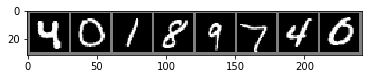

    4     0     1     8     9     7     4     0


In [109]:
def imshow(img):
    
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
#     Permute the axes 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
images, labels = images[0:8], labels[0:8]

imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s" % classes[labels[j]] for j in range(len(labels))))

In [110]:
def g_sampler(batch=50):
    return torch.rand([batch, 100, 1, 1])
print(g_sampler().size())
print(g_sampler().squeeze())

torch.Size([50, 100, 1, 1])

 0.6405  0.8341  0.5623  ...   0.1692  0.1899  0.9309
 0.4764  0.3785  0.3306  ...   0.3167  0.4202  0.0913
 0.3392  0.1642  0.8319  ...   0.3107  0.7987  0.8282
          ...             ⋱             ...          
 0.9208  0.0099  0.0830  ...   0.3183  0.1427  0.2267
 0.8779  0.0026  0.9324  ...   0.9291  0.2181  0.8984
 0.7666  0.9586  0.9931  ...   0.2405  0.1927  0.2519
[torch.FloatTensor of size 50x100]



In [141]:
G = Generator()
D = Discriminator()
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters())
g_optimizer = optim.Adam(G.parameters())

In [164]:
def training(G, D, criterion, d_optimizer, g_optimizer, dataiter, g_sampler, num_epochs=1, epoch_int=1, d_steps=1, g_steps=1, ):
    for epoch in range(num_epochs):
        for d_i in range(d_steps):
            D.zero_grad()
            
            #on real
            d_real_images, _  = dataiter.next()
            d_real_images = Variable(d_real_images)
            d_real_decision = D(d_real_images)
            print(d_real_decision.squeeze().size())
            d_real_error = criterion(d_real_decision.squeeze(), Variable(torch.ones([50])))
            d_real_error.backward()
            
            # on fake
            d_gen_input = Variable(g_sampler())
            d_fake_images = G(d_gen_input).detach()
            d_fake_decision = D(d_fake_images)
            d_fake_error = criterion(d_fake_decision.squeeze(), Variable((torch.zeros([50]))))
            d_fake_error.backward()
            
            d_optimizer.step()
        for g_i in range(g_steps):
            G.zero_grad()
            
            gen_input = Variable(g_sampler())
            g_fake_images = G(gen_input)
            fake_decsion = D(g_fake_images)
            g_error = criterion(fake_decsion.squeeze(), Variable((torch.ones([50]))))
            g_error.backward()
            g_optimizer.step()
        
        if epoch % epoch_int == 0:
            print("%3s / %3s epochs"% (epoch, num_epochs))
#             print(g_fake_images.data.size())
            imshow(torchvision.utils.make_grid(g_fake_images.data[0:3]))
    
    print("Training Complete!")

torch.Size([50])
  0 /   1 epochs


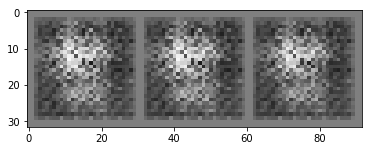

Training Complete!


In [165]:
training(G=G,
         D=D,
         criterion=criterion,
         d_optimizer=d_optimizer,
         g_optimizer=g_optimizer,
         g_sampler=g_sampler,
         dataiter=dataiter
        )

In [133]:
torch.LongTensor(np.ones([50])).size()

torch.Size([50])